In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
## you will need to use the properties_2017 and predictions_2017 tables.

## square feet of the house ("living square feet"), number of bedrooms, number of bathrooms, the assess value of the house by the tax appraisal district ('taxvaluedollarcnt'...this will be your target variable in the project), and 2-3 other variables

## may, june, july or august (date is in predictions_2017 table)

## single unit property values

In [4]:
sql = '''
select parcelid, calculatedfinishedsquarefeet as square_feet, bedroomcnt as bedrooms, bathroomcnt as bathrooms, yearbuilt, fips, lotsizesquarefeet as lot_size, taxvaluedollarcnt as tax_value
from properties_2017
join predictions_2017 using(parcelid)
where transactiondate between "2017-05-01" and "2017-08-31"
AND propertylandusetypeid > 250
AND propertylandusetypeid < 280 
AND propertylandusetypeid != 270 
AND propertylandusetypeid != 271
OR  unitcnt = 1;
'''

In [5]:
df = pd.read_sql(sql, get_connection('zillow'))

In [6]:
df.head()

,parcelid,square_feet,bedrooms,bathrooms,yearbuilt,fips,lot_size,tax_value
0,12177905,2376.0,4.0,3.0,1970.0,6037.0,13038.0,145143.0
1,10887214,1312.0,3.0,3.0,1964.0,6037.0,278581.0,119407.0
2,12095076,2962.0,4.0,3.0,1950.0,6037.0,63000.0,773303.0
3,12069064,738.0,2.0,1.0,1922.0,6037.0,4214.0,218552.0
4,12790562,3039.0,4.0,3.0,1970.0,6037.0,20028.0,220583.0


In [7]:
df.shape

(62159, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62159 entries, 0 to 62158
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcelid     62159 non-null  int64  
 1   square_feet  62040 non-null  float64
 2   bedrooms     62159 non-null  float64
 3   bathrooms    62159 non-null  float64
 4   yearbuilt    62015 non-null  float64
 5   fips         62159 non-null  float64
 6   lot_size     57158 non-null  float64
 7   tax_value    62158 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.8 MB


In [9]:
print(df.isnull().sum())

parcelid          0
square_feet     119
bedrooms          0
bathrooms         0
yearbuilt       144
fips              0
lot_size       5001
tax_value         1
dtype: int64


In [10]:
print(df.columns[df.isnull().any()])

Index(['square_feet', 'yearbuilt', 'lot_size', 'tax_value'], dtype='object')


In [11]:
df.to_csv("zillow.csv") 

In [12]:
df = df.dropna()

## drop rows with null values

In [13]:
df.shape

(57060, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57060 entries, 0 to 62158
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcelid     57060 non-null  int64  
 1   square_feet  57060 non-null  float64
 2   bedrooms     57060 non-null  float64
 3   bathrooms    57060 non-null  float64
 4   yearbuilt    57060 non-null  float64
 5   fips         57060 non-null  float64
 6   lot_size     57060 non-null  float64
 7   tax_value    57060 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.9 MB


In [15]:
print(df.isnull().sum())

parcelid       0
square_feet    0
bedrooms       0
bathrooms      0
yearbuilt      0
fips           0
lot_size       0
tax_value      0
dtype: int64


In [16]:
df = df.set_index("parcelid")

df.head()

,square_feet,bedrooms,bathrooms,yearbuilt,fips,lot_size,tax_value
parcelid,,,,,,,
12177905,2376.0,4.0,3.0,1970.0,6037.0,13038.0,145143.0
10887214,1312.0,3.0,3.0,1964.0,6037.0,278581.0,119407.0
12095076,2962.0,4.0,3.0,1950.0,6037.0,63000.0,773303.0
12069064,738.0,2.0,1.0,1922.0,6037.0,4214.0,218552.0
12790562,3039.0,4.0,3.0,1970.0,6037.0,20028.0,220583.0


In [17]:
df['house_age'] = (2021 - df.yearbuilt).astype('int')

df.head()

,square_feet,bedrooms,bathrooms,yearbuilt,fips,lot_size,tax_value,house_age
parcelid,,,,,,,,
12177905,2376.0,4.0,3.0,1970.0,6037.0,13038.0,145143.0,51
10887214,1312.0,3.0,3.0,1964.0,6037.0,278581.0,119407.0,57
12095076,2962.0,4.0,3.0,1950.0,6037.0,63000.0,773303.0,71
12069064,738.0,2.0,1.0,1922.0,6037.0,4214.0,218552.0,99
12790562,3039.0,4.0,3.0,1970.0,6037.0,20028.0,220583.0,51


In [18]:
## remove outliers 

index3500 = df.loc[df['square_feet'] >= 3500].index

df.drop(index3500 , inplace=True)

In [19]:
df.shape

(54342, 8)

In [20]:
index_tax_value = df.loc[df['tax_value'] >= 5000000].index

df.drop(index_tax_value , inplace=True)

In [21]:
df.shape

(54317, 8)

In [22]:
# Calculate the interquartile range for your column

q1, q3 = df.lot_size.quantile([.25, .75])

iqr = q3 - q1


In [23]:
# Create variables holding upper and lower cutoff values using common formula. Tweak as you like.

upperbound = q3 + 1.5 * iqr

lowerbound = q1 - 1.5 * iqr

In [24]:
upperbound

23778.0

In [25]:
lowerbound

-4998.0

In [26]:
# Filter the column using your variables and reassign to your dataframe.

index_lot_size = df.loc[df['lot_size'] >= 23778.0].index

df.drop(index_lot_size , inplace=True)

In [27]:
df.shape

(44910, 8)

<AxesSubplot:>

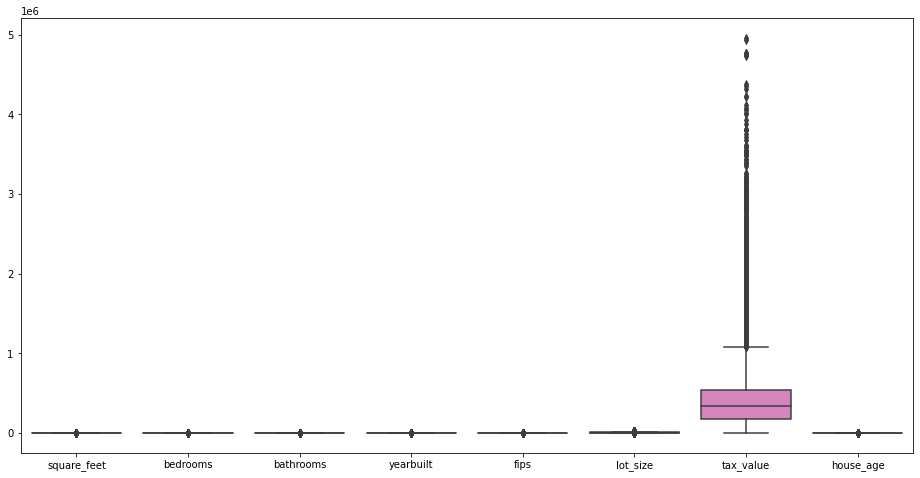

In [28]:
plt.figure(figsize=(16,8))

sns.boxplot(data=df)

<AxesSubplot:>

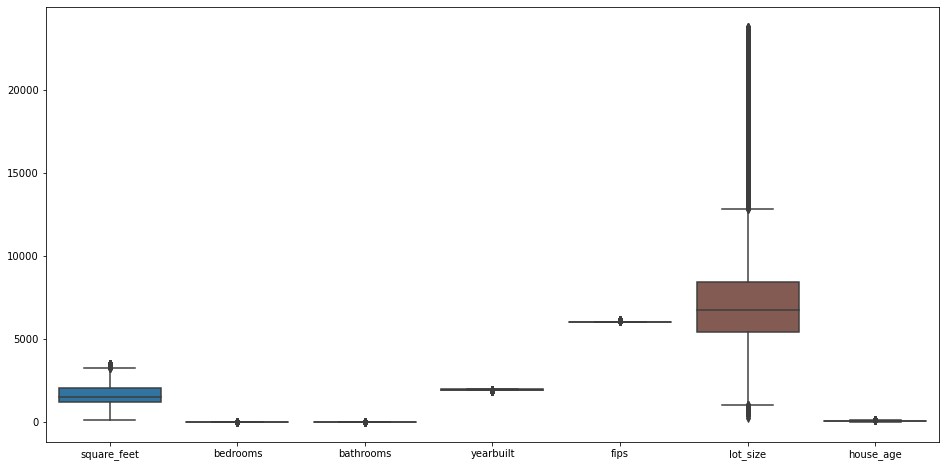

In [29]:
plt.figure(figsize=(16,8))

sns.boxplot(data=df.drop(columns=['tax_value']))

In [30]:
df.bedrooms.value_counts()

# there are house with no bedrooms, those should be removed 

3.0    20636
4.0    11332
2.0     9606
5.0     2058
1.0      886
6.0      236
0.0      121
7.0       29
8.0        5
9.0        1
Name: bedrooms, dtype: int64

In [31]:
index_bedrooms = df.loc[df['bedrooms'] == 0].index

df.drop(index_bedrooms , inplace=True)

In [32]:
df.shape

(44789, 8)

In [33]:
df.bathrooms.value_counts()

# structures with no bathrooms sound also be removed 

2.0    20137
3.0    10500
1.0     9322
2.5     2326
4.0     1372
1.5      506
3.5      360
5.0      169
4.5       69
6.0       15
5.5        4
7.0        4
0.0        4
7.5        1
Name: bathrooms, dtype: int64

In [34]:
index_bathrooms = df.loc[df['bathrooms'] == 0].index

df.drop(index_bathrooms , inplace=True)

In [35]:
df.shape

(44785, 8)

In [39]:
def wrangle_zillow():
    data = pd.read_csv("zillow.csv")
    
    data['house_age'] = (2021 - data.yearbuilt)
    
    data = data.drop(columns = ['Unnamed: 0', 'yearbuilt'])
    
    ## remove outliers 

    index3500 = data.loc[data['square_feet'] >= 3500].index
    data.drop(index3500 ,  inplace=True)
    
    index_tax_value = data.loc[data['tax_value'] >= 5000000].index
    data.drop(index_tax_value ,  inplace=True)
    
    index_lot_size = data.loc[data['lot_size'] >= 23778.0].index
    data.drop(index_lot_size ,  inplace=True)
    
    index_bedrooms = data.loc[data['bedrooms'] == 0].index
    data.drop(index_bedrooms , inplace=True)
    
    index_bathrooms = data.loc[data['bathrooms'] == 0].index
    data.drop(index_bathrooms , inplace=True)
    
    data = data.set_index("parcelid")
    
    data = data.dropna()
    # remove all NaN values
    
    # Remove decimal
    data['bedrooms'] = data['bedrooms'].astype(int)
    data['bathrooms'] = data['bathrooms'].astype(int)
    data['fips'] = data['fips'].astype(int)
    data['house_age'] = data['house_age'].astype(int)
    
    return data

In [40]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name
    """
    
    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=319)
        train, validate = train_test_split(train, test_size=.3, random_state=319)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=319, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=319, stratify=train[stratify_by])
    
    return train, validate, test

In [41]:
df2 = wrangle_zillow()

In [42]:
df2.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,tax_value,house_age
parcelid,,,,,,,
12177905,2376.0,4,3,6037,13038.0,145143.0,51
12069064,738.0,2,1,6037,4214.0,218552.0,99
12790562,3039.0,4,3,6037,20028.0,220583.0,51
11104527,2540.0,4,3,6037,10384.0,430108.0,22
11830315,1146.0,2,1,6037,4657.0,273745.0,82


In [43]:
df2.shape

(44785, 7)

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44785 entries, 12177905 to 13083743
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   square_feet  44785 non-null  float64
 1   bedrooms     44785 non-null  int64  
 2   bathrooms    44785 non-null  int64  
 3   fips         44785 non-null  int64  
 4   lot_size     44785 non-null  float64
 5   tax_value    44785 non-null  float64
 6   house_age    44785 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 2.7 MB


In [45]:
df2.describe()

,square_feet,bedrooms,bathrooms,fips,lot_size,tax_value,house_age
count,44785.000000,44785.000000,44785.000000,44785.000000,44785.000000,4.478500e+04,44785.000000
mean,1673.045596,3.109948,2.100882,6044.768181,7586.903606,4.226248e+05,58.818846
std,627.997114,0.883038,0.789555,18.177903,3881.704877,3.712430e+05,22.755302
min,152.000000,1.000000,1.000000,6037.000000,236.000000,3.254000e+03,5.000000
25%,1208.000000,3.000000,2.000000,6037.000000,5446.000000,1.825420e+05,42.000000
50%,1541.000000,3.000000,2.000000,6037.000000,6720.000000,3.421680e+05,62.000000
75%,2038.000000,4.000000,3.000000,6037.000000,8400.000000,5.440000e+05,71.000000
max,3499.000000,9.000000,7.000000,6111.000000,23772.000000,4.961367e+06,143.000000


In [46]:
train, validate, test = split(df2)

In [47]:
train.shape

(25079, 7)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25079 entries, 12543890 to 11550995
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   square_feet  25079 non-null  float64
 1   bedrooms     25079 non-null  int64  
 2   bathrooms    25079 non-null  int64  
 3   fips         25079 non-null  int64  
 4   lot_size     25079 non-null  float64
 5   tax_value    25079 non-null  float64
 6   house_age    25079 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.5 MB


In [49]:
validate.shape

(10749, 7)

In [50]:
test.shape

(8957, 7)

In [51]:
def scale_data(train, validate, test):
    
    '''
    This function will scale numeric data using Min Max transform after 
    it has already been split into train, validate, and test.
    '''
    
    # Make the thing
    scaler = sklearn.preprocessing.MinMaxScaler()
    
    # We fit on the training data
    # we only .fit on the training data
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    test_scaled = scaler.transform(test)
    
    # turn the numpy arrays into dataframes
    train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
    validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
    test_scaled = pd.DataFrame(test_scaled, columns=train.columns)
    
    return train_scaled, validate_scaled, test_scaled

In [52]:
X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [53]:
X_train.shape

(25079, 6)

In [54]:
y_train.shape

(25079,)

In [55]:
def seperate_y(train, validate, test):
    X_train = train.drop(columns=['tax_value'])
    y_train = train.tax_value

    X_validate = validate.drop(columns=['tax_value'])
    y_validate = validate.tax_value

    X_test = test.drop(columns=['tax_value'])
    y_test = test.tax_value
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [56]:
X_train, y_train, X_validate, y_validate, X_test, y_test = seperate_y(train, validate, test)

In [57]:
X_train.shape

(25079, 6)

In [58]:
y_train.shape

(25079,)

In [59]:
X_validate.shape

(10749, 6)

In [60]:
y_validate.shape

(10749,)

In [61]:
X_test.shape

(8957, 6)

In [62]:
y_test.shape

(8957,)

In [63]:
X_train.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
parcelid,,,,,,
12543890,1107.0,2,2,6037,14887.0,48
14114647,1384.0,3,2,6059,8250.0,65
12235411,1730.0,3,1,6037,6972.0,82
14055296,1254.0,4,1,6059,880.0,58
10877182,1640.0,6,3,6037,6706.0,73


In [64]:
X_validate.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
parcelid,,,,,,
12780254,1583.0,3,2,6037,8356.0,72
11191651,2996.0,3,3,6037,8385.0,16
12046802,1381.0,3,2,6037,8245.0,70
10796147,1800.0,3,3,6037,13561.0,61
12949107,1723.0,3,2,6037,8223.0,66


In [65]:
X_test.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
parcelid,,,,,,
12130305,3229.0,4,4,6037,17337.0,68
11013393,1040.0,3,2,6037,11613.0,60
12273036,913.0,2,1,6037,6637.0,105
14178219,2501.0,4,3,6059,8250.0,57
10935536,1543.0,3,1,6037,5901.0,81


In [66]:
train_scaled, validate_scaled, test_scaled = scale_data(X_train, X_validate, X_test)

In [67]:
train_scaled.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
0,0.285330,0.125,0.166667,0.000000,0.622493,0.311594
1,0.368091,0.250,0.166667,0.297297,0.340500,0.434783
2,0.471467,0.250,0.000000,0.000000,0.286200,0.557971
3,0.329250,0.375,0.000000,0.297297,0.027362,0.384058
4,0.444577,0.625,0.333333,0.000000,0.274898,0.492754


In [68]:
validate_scaled.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
0,0.427547,0.25,0.166667,0.0,0.345003,0.485507
1,0.849716,0.25,0.333333,0.0,0.346236,0.079710
2,0.367195,0.25,0.166667,0.0,0.340287,0.471014
3,0.492381,0.25,0.333333,0.0,0.566154,0.405797
4,0.469376,0.25,0.166667,0.0,0.339352,0.442029


In [69]:
test_scaled.head()

,square_feet,bedrooms,bathrooms,fips,lot_size,house_age
0,0.919331,0.375,0.500000,0.000000,0.726589,0.456522
1,0.265312,0.250,0.166667,0.000000,0.483387,0.398551
2,0.227368,0.125,0.000000,0.000000,0.271966,0.724638
3,0.701823,0.375,0.333333,0.297297,0.340500,0.376812
4,0.415596,0.250,0.000000,0.000000,0.240695,0.550725
